In [1]:
import sys
sys.path.insert(0, '../')

# module imports
import pandas as pd
import numpy
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from collections import Counter
from itertools import chain
import ast
import random
from datetime import datetime
from importlib import reload

# local imports
from fit_model import fit
import BERT
import build_dataset
import baseline
import fit_model

# reload modules
reload(BERT)
reload(build_dataset)
reload(baseline)
reload(fit_model)


# For reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
variant = "bert_user"

In [3]:
test_model = torch.load(f"../saved_models/{variant}.pt")

In [4]:
# load data from csv
DATASET_PATH = "../../data/final_data_200.csv"
df = pd.read_csv(DATASET_PATH)

In [5]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tqdm import tqdm

BATCH_SIZE = 8 
num_workers = 4


# Function for setting seed (assuming it's defined)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


# split data into train, val, test
train_df, val_df, test_df = build_dataset.stratified_user_week_split(df, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15, ensure_user_in_all_sets=True)

# compute ranks for each user based on the train set
rank_dict = build_dataset.compute_rank_dict(train_df)

# create vocabulary based on the whole dataset
dataset = build_dataset.BertMobilityDataset(df,rank_dict)
vocab = dataset.vocab 

# Initialize the datasets with the rank dictionary and vocabulary
train_dataset = build_dataset.BertMobilityDataset(train_df,rank_dict, vocab)
val_dataset = build_dataset.BertMobilityDataset(val_df, rank_dict, vocab)
test_dataset = build_dataset.BertMobilityDataset(test_df, rank_dict, vocab)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, worker_init_fn=seed_worker, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, num_workers=num_workers)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ntokens_location = len(vocab)

In [7]:
def set_global_seeds(seed):
    """
    Set the seed for all relevant libraries to ensure reproducibility.
    """
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)  # For CUDA devices
    
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python's built-in random module

# Set a global seed
set_global_seeds(42)

In [8]:
from fit_model import masked_loss
def test_loop(model, dataloader, src_vocab):
    """
    This method performs evaluation on the test set.

    :param model: The model to be evaluated.
    :param dataloader: DataLoader for the test dataset.
    :param src_vocab: Source vocabulary size.
    """
    # Set the model to evaluation mode.
    model.eval()
    
    # Initialize variables for total loss and accuracy.
    total_test_loss = 0
    correct_predictions = 0
    total_predictions = 0
    predicted_labels_list, true_labels_list = [], []
    accuracy_list = []

    # Use torch.no_grad() for evaluation to reduce memory usage.
    with torch.no_grad():
        for X in dataloader:
            # Move tensors to the same device as the model.
            for k in X.keys():
                if k != 'user':
                    X[k] = X[k].to(device)

            # Extract features and masked tokens.
            features = [k for k in X.keys() if k != 'y' and k != 'user']
            masked_tokens, random_mask = build_dataset.torch_mask_tokens(X['y'], src_vocab)

            # Apply mask.
            for k in features:
                X[k][random_mask] = 0 

            # Prepare inputs for the model.
            y_input = [masked_tokens, *[X[k].view(X[k].size(0), X[k].size(1), -1).float() for k in features]]
            y_expected = X['y']

            # Create a mask for non-padded tokens.
            src_mask = ((X['y'] != 0).int()).to(device)
            src_mask = src_mask.unsqueeze(-1)

            # Get model predictions.
            pred = model(masked_tokens, src_mask) # masked_tokens if without FusionEmbeddings otherwise y_input

            # Calculate loss.
            test_loss = masked_loss(pred, y_expected, random_mask)
            total_test_loss += test_loss.detach().item()

            # Calculate accuracy.
            y_predicted = torch.argmax(pred, dim=-1)
            true_labels = y_expected[random_mask]
            predicted_labels = y_predicted[random_mask]
            correct_predictions += (true_labels == predicted_labels).sum().item()
            total_predictions += true_labels.size(0)
            predicted_labels_list += predicted_labels.tolist()
            true_labels_list += true_labels.tolist()
            accuracy_list.append((true_labels == predicted_labels).sum().item() / true_labels.size(0))

    # Compute average loss and accuracy.
    avg_test_loss = total_test_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    # Log and return the results.
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return avg_test_loss, masked_tokens, accuracy, y_expected, y_predicted, true_labels_list, predicted_labels_list, accuracy_list


In [9]:
measures_test = test_loop(test_model, test_loader, ntokens_location)
avg_test_loss, masked_tokens, accuracy, y_expected, y_predicted, true_labels_list, predicted_labels_list,accuracy_list = measures_test

Test Loss: 3.4824, Test Accuracy: 0.3746


### comparison true labels with predicted labels

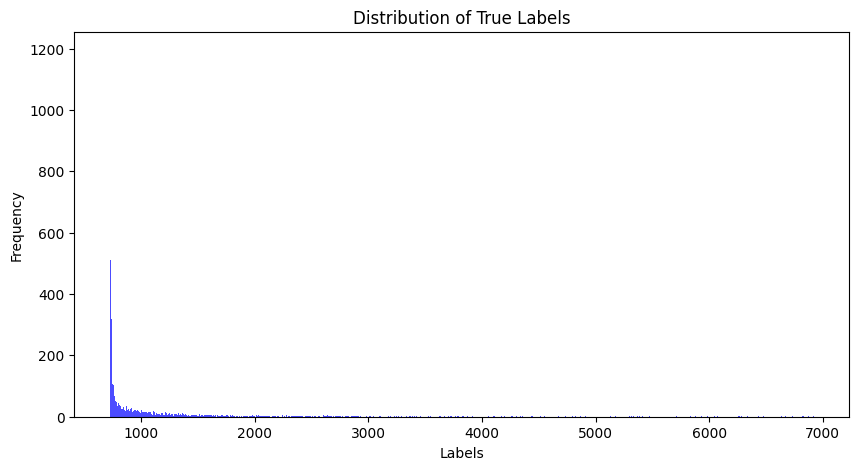

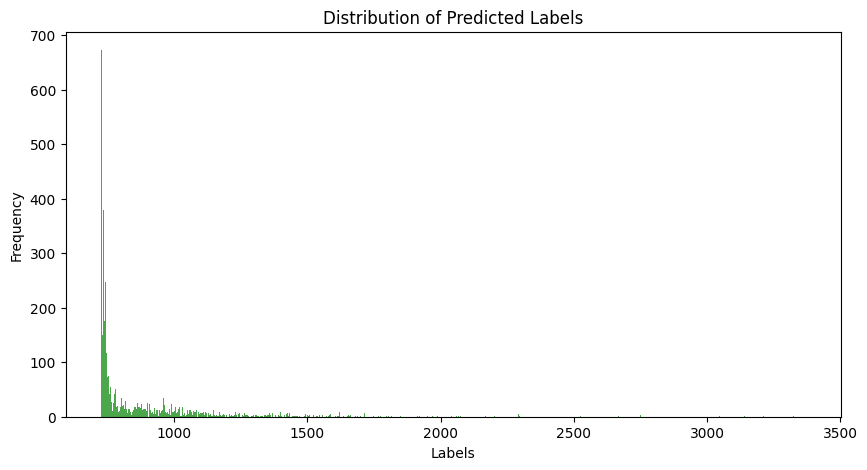

In [10]:
import matplotlib.pyplot as plt

# Plot for True Labels
plt.figure(figsize=(10, 5))
plt.hist(true_labels_list, bins=1000, alpha=0.7, color='blue')
plt.title('Distribution of True Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

# Plot for Predicted Labels
plt.figure(figsize=(10, 5))
plt.hist(predicted_labels_list, bins=1000, alpha=0.7, color='green')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()


In [37]:
from collections import defaultdict

correct_predictions_counter = defaultdict(int)
total_occurrences_counter = defaultdict(int)

for true_label, predicted_label in zip(true_labels_list, predicted_labels_list):
    total_occurrences_counter[true_label] += 1
    if true_label == predicted_label:
        correct_predictions_counter[true_label] += 1

# Calculate the ratio of correct predictions for each label
accuracy_ratio_per_label = {
    label: correct_predictions_counter[label] / total_occurrences_counter[label]
    for label in total_occurrences_counter
}
# Create a DataFrame from the collected data
labels_data = {
    'label': list(total_occurrences_counter.keys()),
    'accuracy_ratio': [accuracy_ratio_per_label[label] for label in total_occurrences_counter],
    'correct_predictions': [correct_predictions_counter[label] for label in total_occurrences_counter],
    'total_occurrences': [total_occurrences_counter[label] for label in total_occurrences_counter]
}
labels_df = pd.DataFrame(labels_data)


In [38]:
labels_df

,label,accuracy_ratio,correct_predictions,total_occurrences
0,732,0.616162,61,99
1,730,0.159292,18,113
2,868,0.000000,0,3
3,728,0.104972,19,181
4,725,0.268908,64,238
...,...,...,...,...
1105,1586,0.000000,0,3
1106,2955,0.000000,0,1
1107,2713,0.000000,0,1
1108,2652,0.000000,0,1


In [39]:
# set up bins for the heatmap
lat_bins = np.linspace(55.52217281782121, 55.88796262687908, 200)
lon_bins = np.linspace(11.987848798727102, 12.734717261629013, 200)

In [40]:
def decode_positions(indices, vocab):
    return [vocab[i] for i in indices]
# Convert bin numbers to center points of the bins
def get_center_points(coord_tuples):
    center_points = []
    for lat_bin, lon_bin in coord_tuples:
        lat_center = (lat_bins[lat_bin - 1] + lat_bins[lat_bin]) / 2
        lon_center = (lon_bins[lon_bin - 1] + lon_bins[lon_bin]) / 2
        center_points.append((lat_center, lon_center))
    return center_points 

In [44]:
labels_df[labels_df['total_occurrences'] >= 5].sort_values(by='total_occurrences', ascending=False)

,label,accuracy_ratio,correct_predictions,total_occurrences
4,725,0.268908,64,238
16,727,0.459574,108,235
6,726,0.254386,58,228
3,728,0.104972,19,181
1,730,0.159292,18,113
...,...,...,...,...
135,821,0.000000,0,5
980,1085,1.000000,5,5
986,816,1.000000,5,5
991,864,0.400000,2,5


In [72]:
# Filter labels with 'Total Occurrences' greater than 5
labels_info = labels_df[labels_df['total_occurrences'] > 5]

# Assuming decode_positions function extracts the coordinates for the labels and get_center_points calculates the center points
top_labels_string = decode_positions(labels_info['label'].tolist(), vocab)
top_labels_tuples = [eval(coord) for coord in top_labels_string]

# Adjusting to get center points
top_labels_center_points = get_center_points(top_labels_tuples)

In [73]:
import folium
from branca.element import Template, MacroElement

# Initialize a map
m = folium.Map(location=[55.7, 12.5], zoom_start=11)

# Determine scale for radius based on the distribution of 'Total Occurrences'
max_occurrence = labels_info['total_occurrences'].max()
min_radius, max_radius = 2, 6  # Adjust these values as needed

# Add points to the map with dynamic sizes
for (point, row) in zip(top_labels_center_points, labels_info.itertuples()):
    # Scale the radius according to 'Total Occurrences'
    scaled_radius = ((row.total_occurrences / max_occurrence) * (max_radius - min_radius)) + min_radius
    folium.CircleMarker(
        location=point,
        radius=scaled_radius,  # Use the scaled radius
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)
    
# Define a template string for the legend HTML using SVG for circles
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: 120px; 
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; Total Occurrences Legend<br>
     &nbsp; High &nbsp; <svg height="24" width="24">
       <circle cx="12" cy="12" r="10" fill="blue" />
     </svg><br>
     &nbsp; Medium &nbsp; <svg height="18" width="18">
       <circle cx="9" cy="9" r="7" fill="blue" />
     </svg><br>
     &nbsp; Low &nbsp; <svg height="12" width="12">
       <circle cx="6" cy="6" r="5" fill="blue" />
     </svg>
</div>
'''

# Create and add the legend to the map
legend = folium.Element(legend_html)
m.get_root().html.add_child(legend)

m


In [78]:
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Initialize a map
m = folium.Map(location=[55.7, 12.5], zoom_start=11)

# Define a function to map accuracy ratio to a color
def get_color(accuracy_ratio):
    # Using Matplotlib's colormap to generate a color from a colormap
    cmap = plt.get_cmap('coolwarm')
    # Normalize accuracy_ratio to range between 0 and 1
    norm = plt.Normalize(vmin=labels_info['accuracy_ratio'].min(), vmax=labels_info['accuracy_ratio'].max())
    rgba_color = cmap(norm(accuracy_ratio))
    # Convert RGBA color to hex format for Folium
    hex_color = mcolors.rgb2hex(rgba_color)
    return hex_color

# Normalize total_occurrences for radius size
min_size, max_size = 3, 6  # Define minimum and maximum sizes for the markers
min_occurrences, max_occurrences = labels_info['total_occurrences'].min(), labels_info['total_occurrences'].max()
size_range = max_size - min_size

# Add points to the map with color based on accuracy ratio and size based on total_occurrences
for point, row in zip(center_points, labels_info.itertuples()):
    # Calculate normalized size for the marker
    normalized_size = ((row.total_occurrences - min_occurrences) / (max_occurrences - min_occurrences)) * size_range + min_size
    
    folium.CircleMarker(
        location=point,
        radius=normalized_size,  # Use the normalized size
        color=get_color(row.accuracy_ratio),
        fill=True,
        fill_color=get_color(row.accuracy_ratio)
    ).add_to(m)

m


In [26]:
def tensor_to_list(tensor):
    list_of_lists = []
    for row in tensor:
        # Convert to list and remove zeros
        list_without_padding = [x.item() for x in row if x not in (0, 1, 2, 3)]
        list_of_lists.append(list_without_padding)
    return list_of_lists

In [27]:
# Convert the tensor and remove padding
expected_trajecory = tensor_to_list(y_expected)
predicted_trajecory = tensor_to_list(y_predicted)

In [28]:
import folium
import numpy as np

def plot_trajectory(binned_coords, lat_bins, lon_bins):
    # Convert string coordinates to tuples
    coord_tuples = [eval(coord) for coord in binned_coords]

    # Convert bin numbers to center points of the bins
    center_points = []
    for lat_bin, lon_bin in coord_tuples:
        lat_center = (lat_bins[lat_bin - 1] + lat_bins[lat_bin]) / 2
        lon_center = (lon_bins[lon_bin - 1] + lon_bins[lon_bin]) / 2
        center_points.append((lat_center, lon_center))

    # Create Folium map centered on the first point
    m = folium.Map(location=center_points[0], zoom_start=12)

    # Add points to the map
    folium.PolyLine(center_points, color="blue", weight=2.5, opacity=1).add_to(m)

    return m

In [29]:
import folium
import numpy as np

def plot_multiple_trajectories(list_of_trajectories, lat_bins, lon_bins):
    # Predefined colors for different trajectories
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'lightgreen', 'gray', 'darkred', 'lightblue']

    # Initialize map; center on the first point of the first trajectory
    if list_of_trajectories:
        first_coord = eval(list_of_trajectories[0][0])
        lat_center = (lat_bins[first_coord[0] - 1] + lat_bins[first_coord[0]]) / 2
        lon_center = (lon_bins[first_coord[1] - 1] + lon_bins[first_coord[1]]) / 2
        m = folium.Map(location=(lat_center, lon_center), zoom_start=12)
    else:
        return "No trajectories provided"

    # Process and plot each trajectory
    for idx, trajectory in enumerate(list_of_trajectories):
        color = colors[idx % len(colors)]  # Cycle through colors

        # Convert string coordinates to tuples and then to center points
        coord_tuples = [eval(coord) for coord in trajectory]
        center_points = []
        for lat_bin, lon_bin in coord_tuples:
            lat_center = (lat_bins[lat_bin - 1] + lat_bins[lat_bin]) / 2
            lon_center = (lon_bins[lon_bin - 1] + lon_bins[lon_bin]) / 2
            center_points.append((lat_center, lon_center))

        # Add trajectory to the map
        folium.PolyLine(center_points, color=color, weight=2.5, opacity=1).add_to(m)

    return m

In [32]:
# remove the first elements in the lists in expected_trajecory
# [x[1:] for x in expected_trajecory]

[[882,
  726,
  882,
  731,
  882,
  726,
  731,
  882,
  726,
  725,
  882,
  1330,
  1708,
  882,
  726,
  740,
  729,
  746,
  729,
  740,
  882,
  1521,
  882,
  2272,
  1521,
  882],
 [882, 1308, 882, 749, 882, 1708, 882, 898, 882, 1613, 882, 1521, 882]]

In [31]:
plot_multiple_trajectories([[vocab[i] for i in l] for l in [x[1:] for x in expected_trajecory]], lat_bins, lon_bins)

In [33]:
plot_multiple_trajectories([[vocab[i] for i in l] for l in predicted_trajecory], lat_bins, lon_bins)